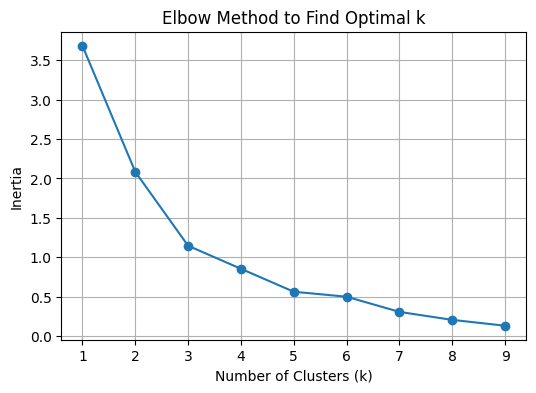

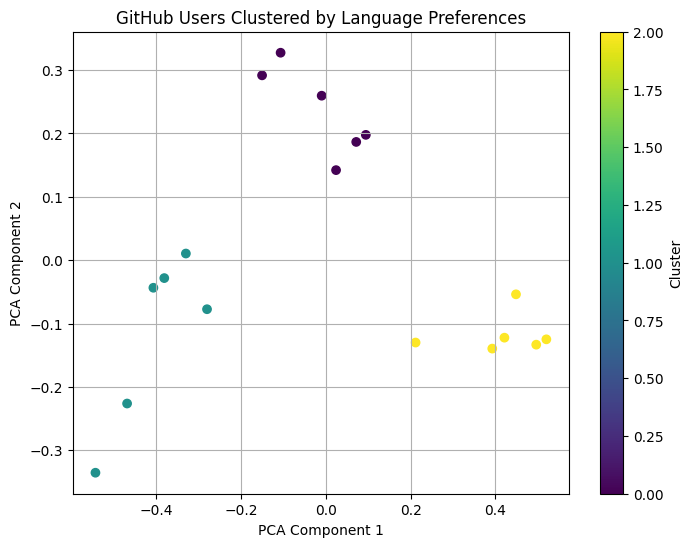


Cluster 0 top languages:
TypeScript      183.0
JavaScript      179.0
C++              24.0
HTML             22.0
CoffeeScript     15.0
dtype: float64

Cluster 1 top languages:
Python     38.0
Haskell    28.0
C++        17.0
Java       10.0
C          10.0
dtype: float64

Cluster 2 top languages:
JavaScript    547.0
TypeScript     25.0
CSS            16.0
Python         15.0
HTML           13.0
dtype: float64


In [1]:
import requests
import pandas as pd
from collections import defaultdict
import time
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#my github token
TOKEN = input("Enter your GitHub token: ")
HEADERS = {"Authorization": f"token {TOKEN}"}

#list of github usernames based on project
usernames = [
    # React (facebook/react)
    "gaearon", "bvaughn", "acdlite", "sophiebits", "trueadm", "sebmarkbage",

    # VS Code (microsoft/vscode)
    "alexdima", "joaomoreno", "Tyriar", "bpasero", "aeschli", "rebornix",

    # TensorFlow (tensorflow/tensorflow)
    "aselle", "martinwicke", "gunan", "apassos", "mihaimaruseac", "yaroslavvb"
]

#using the github api to fetch language data per user
def get_user_languages(username):
    languages = defaultdict(int)
    page = 1
    while True:
        url = f"https://api.github.com/users/{username}/repos?page={page}&per_page=100"
        response = requests.get(url, headers=HEADERS)
        if response.status_code != 200:
            print(f"Error fetching repos for {username}: {response.status_code}")
            break
        repos = response.json()
        if not repos:
            break
        for repo in repos:
            if repo.get("language"):
                languages[repo["language"]] += 1
        page += 1
        time.sleep(1)
    return languages

#collecting the data
user_language_data = []

for user in usernames:
    print(f"Collecting data for {user}")
    lang_data = get_user_languages(user)
    lang_data["user"] = user
    user_language_data.append(lang_data)

#building the DataFrame
df = pd.DataFrame(user_language_data).fillna(0)
df.set_index("user", inplace=True)

#normalizing the language usage in the dataframe
df_normalized = df.div(df.sum(axis=1), axis=0).fillna(0)

#Elbow Method to choose k visualization
inertias = []
k_values = range(1, 10)

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(df_normalized)
    inertias.append(model.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Find Optimal k')
plt.grid(True)
plt.show()

#k = 3 based on elbow plot
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_normalized['cluster'] = kmeans.fit_predict(df_normalized)

#PCA visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_normalized.drop(columns='cluster'))
df_normalized['PCA1'] = pca_result[:, 0]
df_normalized['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_normalized['PCA1'], df_normalized['PCA2'],
                      c=df_normalized['cluster'], cmap='viridis')
plt.title('GitHub Users Clustered by Language Preferences')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

#cluster analysis
df_clustered = df.copy()
df_clustered['cluster'] = df_normalized['cluster']

#view cluster members and their top languages
for c in sorted(df_clustered['cluster'].unique()):
    print(f"\nCluster {c} top languages:")
    cluster_members = df_clustered[df_clustered['cluster'] == c]
    print(cluster_members.drop(columns='cluster').sum().sort_values(ascending=False).head(5))
